## Лабораторная 3: метод ближайших соседей (kNN)

В рамках этого занятия мы будем создавать модель для предсказания выживших пассажиров на "Титанике" (классическое учебное Kaggle [соревнование](https://www.kaggle.com/c/titanic)).

![Титаник](http://staff.mmcs.sfedu.ru/~sguda/MachineLearning/titanic.png)

## 1

Загрузите данные о погибших в катастрофе с "Титаником". Целевым признаком здесь является факт спасения пассажира. Посмотрите на данные.

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('data.csv', delimiter=',')
data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [3]:
data.head(15)

PassengerId  Survived  Pclass  \
0             1         0       3   
1             2         1       1   
2             3         1       3   
3             4         1       1   
4             5         0       3   
5             6         0       3   
6             7         0       1   
7             8         0       3   
8             9         1       3   
9            10         1       2   
10           11         1       3   
11           12         1       1   
12           13         0       3   
13           14         0       3   
14           15         0       3   

                                                 Name     Sex   Age  SibSp  \
0                             Braund, Mr. Owen Harris    male  22.0      1   
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                              Heikkinen, Miss. Laina  female  26.0      0   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                            Allen, Mr. William Henry    male  35.0      0   
5                                    Moran, Mr. James    male   NaN      0   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
7                      Palsson, Master. Gosta Leonard    male   2.0      3   
8   Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                 Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   
12                     Saundercock, Mr. William Henry    male  20.0      0   
13                        Andersson, Mr. Anders Johan    male  39.0      1   
14               Vestrom, Miss. Hulda Amanda Adolfina  female  14.0      0   

    Parch            Ticket     Fare Cabin Embarked  
0       0         A/5 21171   7.2500   NaN        S  
1       0          PC 17599  71.2833   C85        C  
2       0  STON/O2. 3101282   7.9250   NaN        S  
3       0            113803  53.1000  C123        S  
4       0            373450   8.0500   NaN        S  
5       0            330877   8.4583   NaN        Q  
6       0             17463  51.8625   E46        S  
7       1            349909  21.0750   NaN        S  
8       2            347742  11.1333   NaN        S  
9       0            237736  30.0708   NaN        C  
10      1           PP 9549  16.7000    G6        S  
11      0            113783  26.5500  C103        S  
12      0         A/5. 2151   8.0500   NaN        S  
13      5            347082  31.2750   NaN        S  
14      0            350406   7.8542   NaN        S

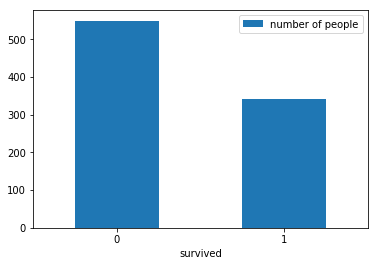

In [4]:
df = pd.DataFrame({'survived':['0', '1'], 'number of people':data['Survived'].value_counts().tolist()})
ax = df.plot.bar(x='survived', y='number of people', rot=0)
plt.show()

Для простоты исключите пассажиров с неизвестным возрастом и заново перенумеруйте строки

*Функции, которые могут пригодиться при решении: `.dropna(subset='Age'), .reset_index(drop=True)`*

In [5]:
print(f"Nulls in data['Age'] before processing: {data['Age'].isnull().values.any()}")

data.dropna(subset=['Age'], inplace=True)
data.reset_index(drop=True, inplace=True)
      
print(f"Nulls in data['Age'] after processing: {data['Age'].isna().values.any()}")

Nulls in data['Age'] before processing: True
Nulls in data['Age'] after processing: False


In [6]:
print(f"Current dataset length: {len(data)}")

Current dataset length: 714


## 2

Постройте график рассеяния с возрастом в качестве оси абсцисс и ценой билета в качестве оси ординат. Отметьте красным — погибших, зеленым — спасшихся пассажиров. Постройте отдельно 2 графика: для женщин и для мужчин. 

Выполняется ли для данного множества гипотеза компактности?

In [7]:
max_fare = data['Fare'].max(skipna=True)
min_fare = data['Fare'].min(skipna=True)

survived = data['Survived'].eq(1)
not_survived = data['Survived'].eq(0)

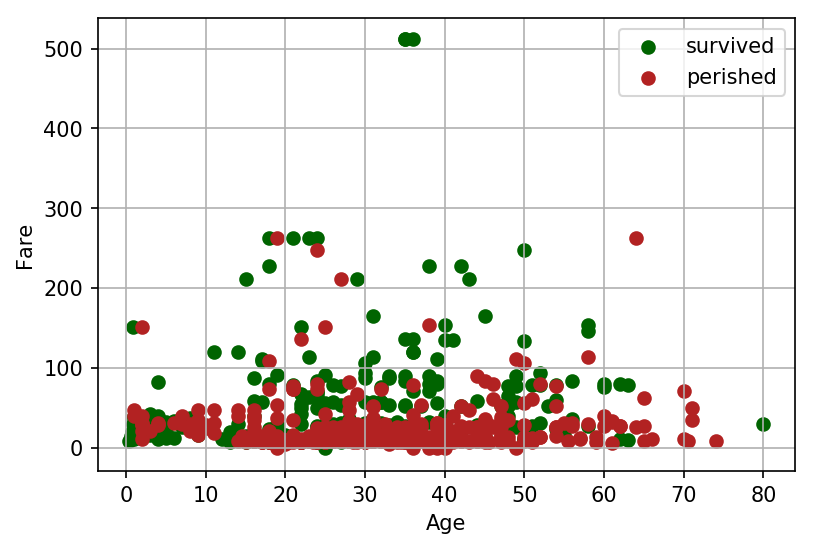

In [8]:
# find debtors in the dataframe
plt.figure(figsize=(6,4),dpi=150)


plt.scatter(data.loc[survived, 'Age'], data.loc[survived, 'Fare'], label='survived', marker='o', c='darkgreen')
plt.scatter(data.loc[not_survived, 'Age'], data.loc[not_survived, 'Fare'],label='perished', marker='o', c='firebrick')

plt.xlabel("Age")
plt.ylabel("Fare")
# plt.ylim(np.exp(min_fare),max_fare)
# plt.yscale('log')

plt.legend()
plt.grid(True)

plt.show()

In [9]:
male = data.loc[data['Sex'].eq('male')]
female = data.loc[data['Sex'].eq('female')]

print(f"Current dataset length: {len(data)}")
print(f"Men: {len(male)}")
print(f"Women: {len(female)}")


Current dataset length: 714
Men: 453
Women: 261


In [26]:
sum(female["Survived"])/len(female)

0.7547892720306514

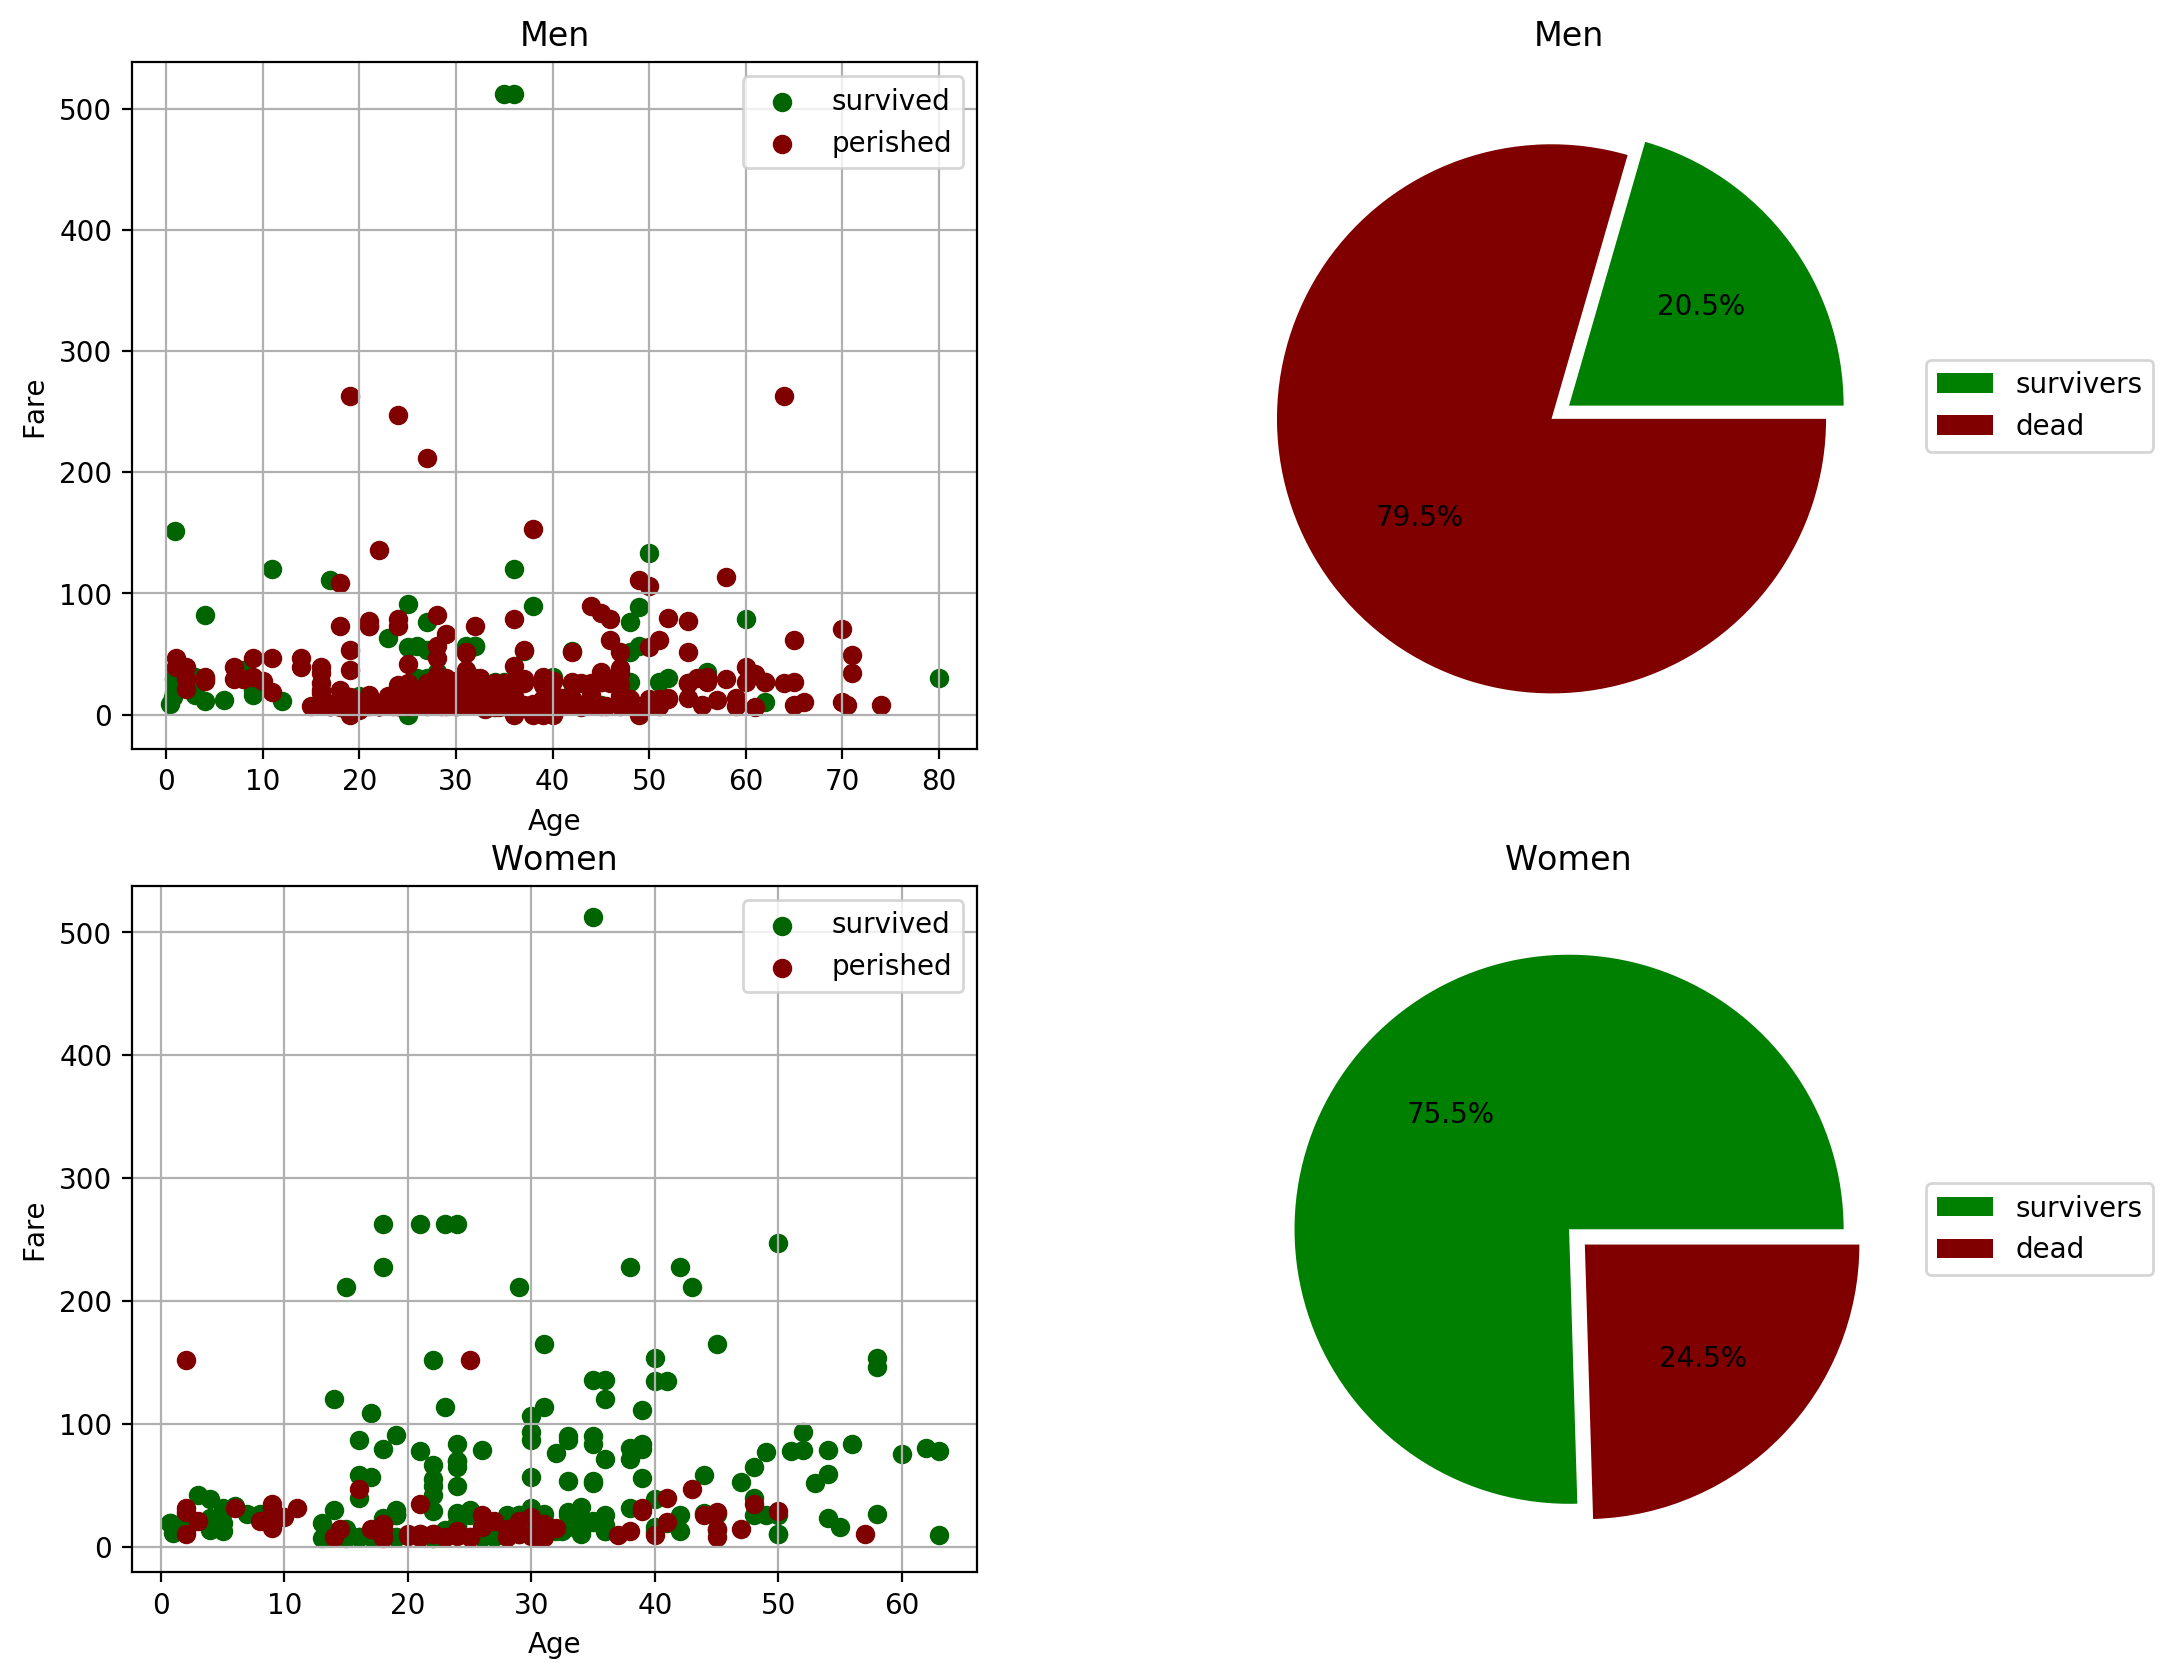

In [32]:
titles = ('Men', 'Women')

fig = plt.figure(figsize=(12,10), dpi=200)
    
for i, sex in enumerate((male, female)):
    sex_survived = sex['Survived'].eq(1)
    sex_not_survived = sex['Survived'].eq(0)
    
    fig.add_subplot(2, 2, 2*i+1)
    
    plt.scatter(sex.loc[sex_survived, 'Age'], sex.loc[sex_survived, 'Fare'], 
                label='survived', marker='o', c='darkgreen')
    plt.scatter(sex.loc[sex_not_survived, 'Age'], sex.loc[sex_not_survived, 'Fare'],
                label='perished', marker='o', c='maroon')

    plt.xlabel("Age")
    plt.ylabel("Fare")
    
    plt.legend()
    plt.grid(True)
    plt.title(titles[i])
    
    fig.add_subplot(2, 2, 2*i+2)

    survived_count = sum(sex["Survived"]) 
    perished = len(sex) - sum(sex["Survived"]) 

    plt.pie([survived_count, perished], colors=['green','maroon'],autopct='%1.1f%%', explode=(0, 0.08))
    plt.legend(['survivers', 'dead'],
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title(titles[i])
    
plt.show()

### Гипотеза компактности, не выполняется, 
### Нельзя очевидным образом выделить два класса пассажиров.

## 3 

Для построения модели нам понадобится метрика близости пассажиров. Запрограммируем функцию вычисления расстояния между пассажирами:

In [33]:
import numpy as np
import tqdm

In [34]:
def distance(a,b):
    d = 0
    d += abs(a['Pclass'] - b['Pclass'])
    d += a['Sex'] != b['Sex']
    d += abs(a['Age'] - b['Age'])
    d += abs(a['SibSp'] - b['SibSp'])
    d += abs(a['Parch'] - b['Parch'])
    d += abs(a['Fare'] - b['Fare'])
    d += a['Embarked'] != b['Embarked']
    return d

Метод `KNeighborsClassifier` из библиотеки `sklearn` излишне требователен к типам данных. Запрограммируем метод `k` ближайших соседей вручную:

In [35]:
def myKNeighborsClassifier(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    prediction = 0
    for i in range(K): 
        prediction += dists[i][1]
    prediction /= K
    return round(prediction)

Запустите предсказание для всех пассажиров судна и, используя LOO-контроль ошибки оцените качество классификации:

In [36]:
accuracy = 0
for idx, row in tqdm.tqdm(data.iterrows(), total=len(data)):
    accuracy += row['Survived'] == myKNeighborsClassifier(data, 5, idx)
print(accuracy/data.shape[0])

100%|██████████| 714/714 [05:06<00:00,  2.33it/s]

0.726890756302521


Подберите слагаемые в метрике, их веса и количество соседей так, чтобы качество классификации было максимальным. 

Если функция на `python` работает долго, воспользуйтесь ее аналогом на 
С++:  `KNeighborsClassifier.cpp.` 

Компиляция на Linux выполняется командой 

    g++ -O2 KNeighborsClassifier.cpp -o  KNeighborsClassifier


Запуск: 

    ./KNeighborsClassifier
    
Построившему метрику с наилучшим качеством: +5 бонусных баллов.

## 4

Создайте копию функции `myKNeighborsClassifier` и измените ее так, чтобы она считала выступ объекта. Назовите ее `calcMargin`. 

Вычислите выступы для всех объектов и выведите информацию о пяти объектах с минимальным выступом (шумовых выбросах) и пяти объектах с максимальным выступом (эталонах). Объясните в комментариях полученные данные.

In [37]:
def calcMargin(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    margin = 0
    for i in range(K): 
        margin += dists[i][1]
    margin /= K
    return margin

In [38]:
margins = []
for idx, row in tqdm.tqdm(data.iterrows(), total=len(data)):
    margins.append(calcMargin(data, 39, idx))

100%|██████████| 714/714 [04:43<00:00,  2.52it/s]


Это легче всего сделать с помощью функции `np.argsort`, возвращающей индексы элементов в отсортированном ряду:

In [39]:
idx = np.argsort(margins)

In [40]:
print('Белые вороны (аномалии)')
data.loc[idx[:5],]

Белые вороны (аномалии)


PassengerId  Survived  Pclass                             Name   Sex  \
643          807         0       1           Andrews, Mr. Thomas Jr  male   
322          401         1       3               Niskanen, Mr. Juha  male   
658          823         0       1  Reuchlin, Jonkheer. John George  male   
375          472         0       3                  Cacic, Mr. Luka  male   
282          351         0       3           Odahl, Mr. Nils Martin  male   

      Age  SibSp  Parch             Ticket    Fare Cabin Embarked  
643  39.0      0      0             112050  0.0000   A36        S  
322  39.0      0      0  STON/O 2. 3101289  7.9250   NaN        S  
658  38.0      0      0              19972  0.0000   NaN        S  
375  38.0      0      0             315089  8.6625   NaN        S  
282  23.0      0      0               7267  9.2250   NaN        S

In [41]:
print('Эталоны (характерные объекты)')
data.loc[idx[-5:],]

Эталоны (характерные объекты)


PassengerId  Survived  Pclass                                Name  \
553          699         0       1            Thayer, Mr. John Borland   
243          306         1       1      Allison, Master. Hudson Trevor   
537          680         1       1  Cardeza, Mr. Thomas Drake Martinez   
563          709         1       1                Cleaver, Miss. Alice   
240          298         0       1        Allison, Miss. Helen Loraine   

        Sex    Age  SibSp  Parch    Ticket      Fare        Cabin Embarked  
553    male  49.00      1      1     17421  110.8833          C68        C  
243    male   0.92      1      2    113781  151.5500      C22 C26        S  
537    male  36.00      0      1  PC 17755  512.3292  B51 B53 B55        C  
563  female  22.00      0      0    113781  151.5500          NaN        S  
240  female   2.00      1      2    113781  151.5500      C22 C26        S

## Как мы можем видеть, в основном выжили женщины и дети. Кроме них большой процент выживания был среди людей, которые купили дорогие билеты.